TARGET: tc_2c_15m
TESTED FEATURES: 
Index(['volume', 'ToD', 'DoW', 'vel1', 'vel2', 'vel3', 'vel4', 'vel5', 'vel6',
       'vel7',
       ...
       'hilo_stoch_120_30', 'hilo_stoch_120_60', 'hilo_stoch_120_120',
       'hilo_stoch_120_240', 'hilo_stoch_240_5', 'hilo_stoch_240_15',
       'hilo_stoch_240_30', 'hilo_stoch_240_60', 'hilo_stoch_240_120',
       'hilo_stoch_240_240'],
      dtype='object', length=435)
TESTING FOR: 
tc_2c_15m

X shape == (107838, 20, 86).
y shape == (107838, 1).

Raw Sample Count:	107838
Remaining Sample Count:	5945

X_train shape == (4161, 20, 86).
y_train shape == (4161, 1).
X_val shape == (1169, 20, 86).
y_val shape == (1169, 1).
X_ind shape == (575, 20, 86).
y_ind shape == (575, 1).

Running on: GPU

Epoch 1/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4874 - loss: 0.7535 - precision: 0.5120 - recall: 0.5087 - val_accuracy: 0.5500 - val_loss: 0.6909 - val_precision: 0.5251 - val_recall: 0.6524 - learning_rate: 5.5000e-04
Epoch 2/150
18/18 ━━

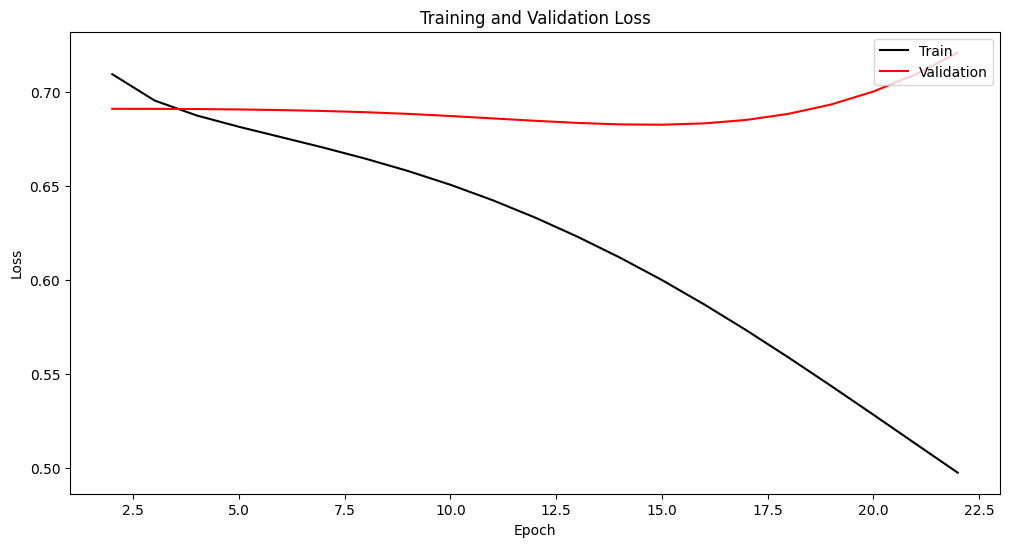

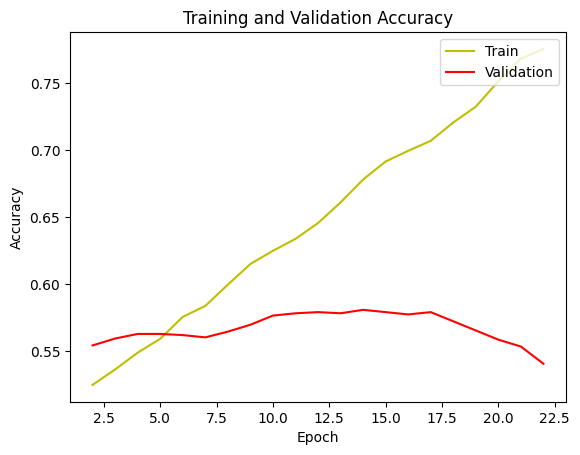

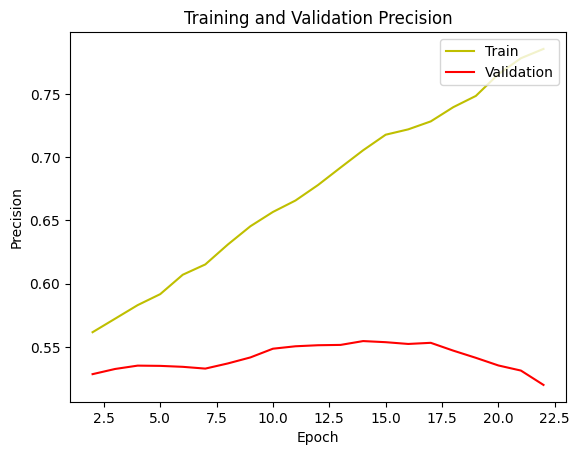

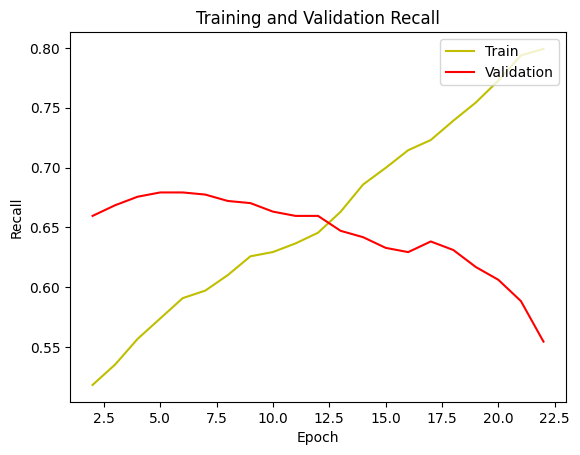

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


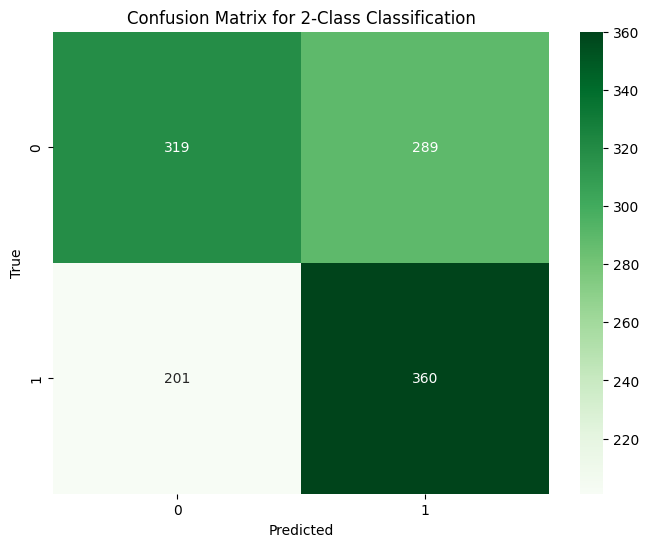

In [8]:
#Logan Kelsch + JJ
'''
/*
 *  taking this version of neural network training takes only a few features
 *          [ high, low, open, close, volume, TimeOfDay, DayOfWeek ]
 *  and uses common techniques described in 'features_creation.py' to largely
 *  expand dimensionality. 
 *  As of writing this (11/24/24) there is limited expansion
*/
''' 

#IMPORT LIBRARIES-------------------------------------------------------

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from keras.optimizers import SGD
from keras.initializers import GlorotUniform
from keras.initializers import RandomNormal
from keras.callbacks import EarlyStopping
#from imblearn.over_sampling import SMOTE
from funcs_data_process import *
from feature_creation import *
from performance_printout import *
from tensorflow.keras.optimizers import AdamW


# Load the dataset
data = pd.read_csv('betaset_tmp.csv')

'''#---------------#
    MODEL VARIABLES
'''#---------------#


indp_size       = 0.1       #size of indepentendent set of samples
test_size       = 0.2       #size of validation set of samples
num_isol_feats  = 0         #number of features to be left out of PCA transformation
                            #   this function is depricated/needs updated
use_PCA         = True      #bool for use of PCA feature decomp. and transformation
comps_PCA       = 86        #number of primary components to use under PCA t.
time_steps      = 20        #LSTM time steps used
t_start         = 570       #start time for time based sample filtering
t_end           = 645       #end   time for time based sample filtering

params = model_params()
params = get_model_params(
    m_type          = 'Classification'      # {'Regression', 'Classification'}

   ,target_time     = 15        #how many minutes in the future is the target
   ,c_split_val     = 5
   ,c_class_cnt     = 2
)


#drop unused target columns
data = set_target(data, params)

#collect all sample indices to be kept through time filter
#two seperate functions to keep main and ind test isolated
keep_ndx = grab_wanted_times(data.values, t_start, t_end, time_steps)

data = data.drop(columns=return_name_collection())
#data = data.drop(columns=fn_orig_price())
data = data.drop(columns=fn_orig_time())

#confirmation printout of all features/targets
Xfeatures = data.columns[:-1]
Yfeatures = data.columns[-1]
print("TESTED FEATURES: ")
print(Xfeatures)
print("TESTING FOR: ")
print(Yfeatures)


# Separate features and target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

params = update_class_weights(y, params)

y, label_encoder = y_preprocess(params, y)

X_nrm = normalize_from_tt_split(X, X, test_size)
if(use_PCA):
    X = reform_with_PCA_isolated(X_nrm, X_nrm, test_size, num_isol_feats, comps_PCA)
X, y = reformat_to_lstm(X, y, time_steps)

print('\nX shape == {}.'.format(X.shape))
print('y shape == {}.\n'.format(y.shape))


print(f'Raw Sample Count:\t{len(X)}')
X,     y     = filter_times(X,     y,     keep_ndx)
print(f'Remaining Sample Count:\t{len(X)}')

#split all samples 3 ways into training, and testing
#   and split all testing into validation and independent
X_train, X_val, X_ind, y_train, y_val, y_ind =\
    split_into_train_val_ind(X, y, test_size, indp_size, time_steps)

inv_trn_y = label_encoder.inverse_transform(y_train)
params = update_class_weights(inv_trn_y, params)

print('\nX_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))
print('X_val shape == {}.'.format(X_val.shape))
print('y_val shape == {}.'.format(y_val.shape))
print('X_ind shape == {}.'.format(X_ind.shape))
print('y_ind shape == {}.\n'.format(y_ind.shape))



#LEARNING RATES____________________________________________________________________________________________
from keras.optimizers.schedules import ExponentialDecay
lr_schedule = ExponentialDecay(
    #good rough val to start, .25, good val to end at .0015.
    #5k epoch should be: .25, 8565, .9995, true
    0.01,
    decay_steps=100,
    decay_rate=0.997,
    staircase=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor=params.monitor_parameter,
    mode=params.monitor_condition,
    factor=0.75, 
    patience=16, 
    min_lr=1e-8
)

opt1 = SGD(learning_rate=0.0001)
opt2  = tf.keras.optimizers.Adam(learning_rate=0.001)
opt3 = SGD(learning_rate=lr_schedule)
opt4 = SGD(learning_rate=0.001, momentum=0.7)
opt5 = tf.keras.optimizers.Adam(learning_rate=0.0005)
opt6 = AdamW(learning_rate=0.00055, weight_decay=0.00)

#BUILD AND LOAD MODEL__________________________________________________________________________________________


#print(X_train.shape[0]/time_steps)
#X_train = np.reshape(X_train,((X_train.shape[0]//time_steps), time_steps, 35))  # Reshape to (batch_size, 5 time steps, 35 features)
#y_train = y.reshape(1,-1)
from tensorflow.keras import regularizers

def build_LSTM_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],X_train.shape[2])),
        tf.keras.layers.LSTM(8, activation='tanh', recurrent_dropout=0.0, return_sequences=True),#, kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        tf.keras.layers.LSTM(8, activation='tanh', recurrent_dropout=0.0, return_sequences=True),#, kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        tf.keras.layers.LSTM(8, activation='tanh', recurrent_dropout=0.0, return_sequences=False),#, kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Dense(16),# kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        #tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Activation('relu'),
        #tf.keras.layers.Dropout(0.0),
        tf.keras.layers.Dense(params.target_neurons, activation=params.target_activation)
    ])
    model.compile(optimizer=opt6,
                  loss=params.loss_function
                  ,metrics=params.performance_metrics)
    return model
'''
def load_model():
    loaded_model = tf.keras.models.load_model('r30_10s_LSTM_8.keras')
    loaded_model.compile(optimizer=opt4,
                         loss='mse'
                         , metrics=['R2Score','root_mean_squared_error'])
    return loaded_model
'''
#TRAIN THE MODEL WITH CUSTOMIZABLE EPOCHS-------------------------------------------------------

epochs = 150

early_stopping = EarlyStopping(monitor=params.monitor_parameter, patience=8, mode=params.monitor_condition, restore_best_weights=True)

cmp = 'C'
if tf.config.list_physical_devices('GPU'):
    cmp = 'G'
    pass
with tf.device('/'+cmp+'PU:0'):
    print('Running on: '+cmp+'PU\n')
    model = build_LSTM_model()
    #loaded_model = load_model()
    used_model = model
    history = model_fit(X_train, y_train, used_model, epochs, 
                        shuffle=False,
                        verbose=1, 
                        validation_data=(X_val, y_val), 
                        batch_size=240,
                        callbacks=[reduce_lr, early_stopping],
                        params=params)

#EVALUATE THE MODEL AND VISUALIZE RESULTS-------------------------------------------------------

#show_all_results(used_model, history, X_test, y_test)

#reformat epochs to remove first sample and
#          add room on right side of graphs
epochs = range(1, len(history.history['loss']) + 1)

#loss printout
graph_loss(epochs=epochs, history=history)

#metric printout
graph_metrics(params=params, epochs=epochs, history=history)

#predicting the test set results
y_pred, y_test = model_predict(used_model, params, X_val, y_val)

#print out prediction relevant graphs
graph_predictions(y_pred, y_test, params, ds_name='Validation')

#save model under all circumstances in a .keras file
used_model.save('tmp.keras')

In [7]:
used_model.save('r30_PCA10_6.keras')

131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


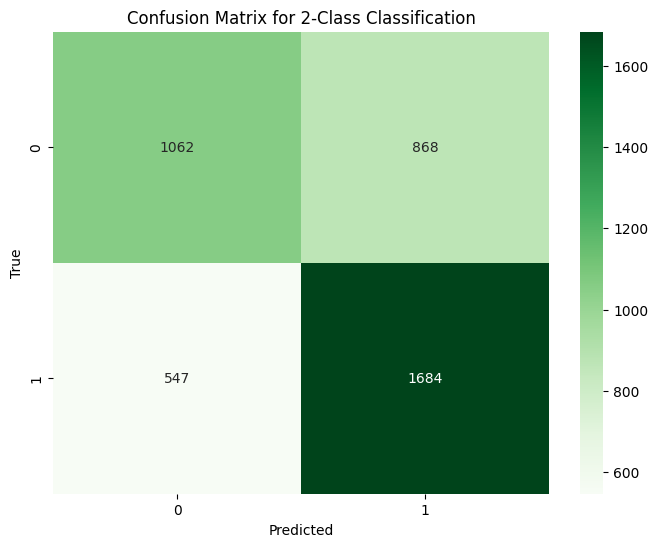

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


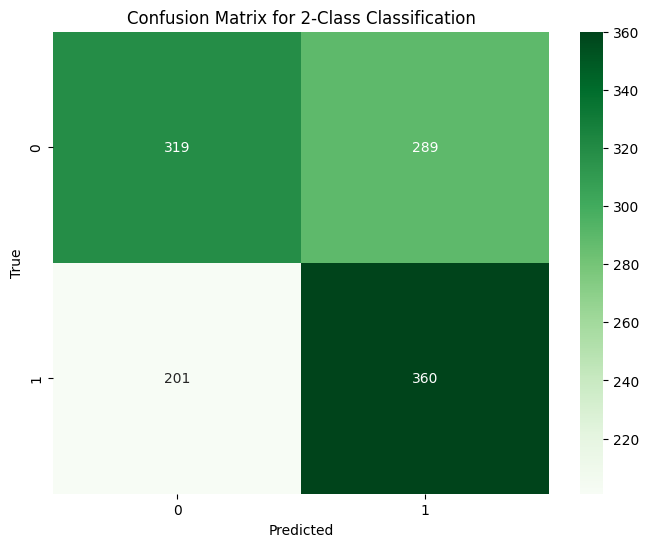

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


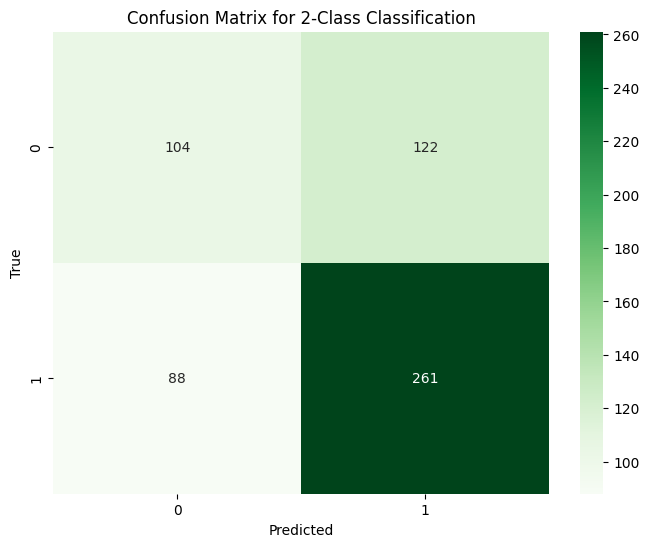

In [9]:
#print out prediction relevant graphs
y_pred, y_true = model_predict(used_model, params, X_train, y_train)
graph_predictions(y_pred, y_true, params, ds_name='Training')
y_pred, y_true = model_predict(used_model, params, X_val, y_val)
graph_predictions(y_pred, y_true, params, ds_name='Validation')
y_pred, y_true = model_predict(used_model, params, X_ind, y_ind)
graph_predictions(y_pred, y_true, params, ds_name='Independent')

131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


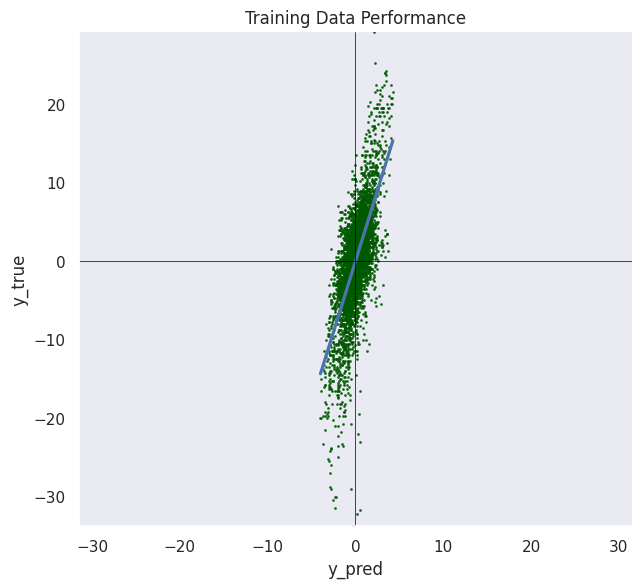

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


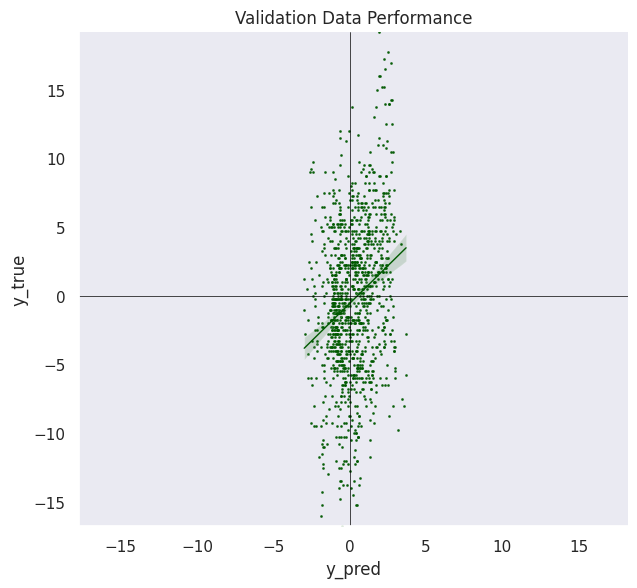

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


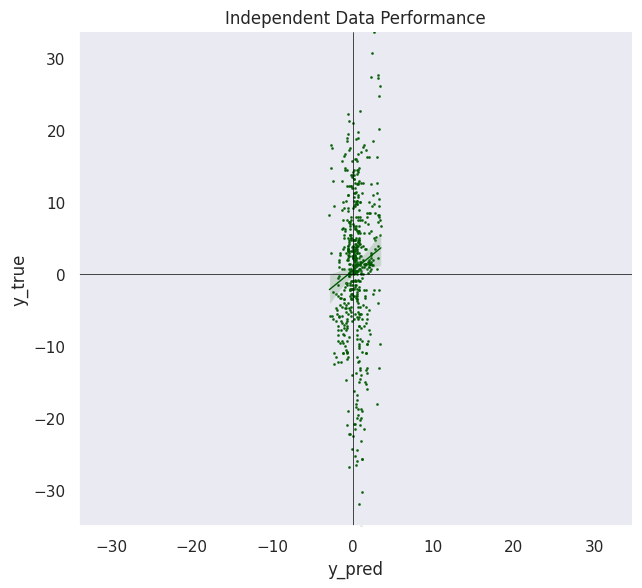

In [ ]:
#new_model = tf.keras.models.load_model("r30_PCA10_1.keras")

'''
plt.figure(figsize=(7, 6))
#SCATTERPLOT #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  
plt.scatter(y_pred, y_exam, s=1)
plt.grid()
plt.axis('tight')
plt.title('Testing Outputs')
plt.xlabel('y_pred')
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.ylabel('y_test')
ax = plt.gca()
x_vals = np.array(ax.get_xlim())
y_vals = x_vals  # Since y = x
plt.plot(x_vals, y_vals, '-', color='black', label='y = x', linewidth=0.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0,color='black',linewidth=0.5)
plt.show()
'''
s_kws = {'s':1,'color':(0,.35,0)}
l_kws = {'lw':1,'color':(0,.35,0)}

import seaborn as sns

#Training set
y_pred = used_model.predict(X_train) 
#sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme()
y_pred = np.squeeze(y_pred)
y = np.squeeze(y)
ys = pd.DataFrame({"y_pred":y_pred,"y_true":y_train})
g = sns.lmplot(data=ys,x="y_pred", y="y_true", scatter_kws=s_kws, line_kws=l_kws)#,hue="MO")
g.fig.set_size_inches(7,6)
plt.title('Training Data Performance')
plt.grid()
y_min, y_max = ys['y_true'].min(), ys['y_true'].max()
plt.ylim(y_min, y_max)
x_center = np.mean(ys['y_pred'])
y_range = y_max - y_min
x_min = x_center - y_range / 2
x_max = x_center + y_range / 2
plt.xlim(x_min, x_max)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0,color='black',linewidth=0.5)
plt.show()

#Validation set
y_pred = used_model.predict(X_val) 
#sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme()
y_pred = np.squeeze(y_pred)
y = np.squeeze(y)
ys = pd.DataFrame({"y_pred":y_pred,"y_true":y_val})
g = sns.lmplot(data=ys,x="y_pred", y="y_true", scatter_kws=s_kws, line_kws=l_kws)#,hue="MO")
g.fig.set_size_inches(7,6)
plt.title('Validation Data Performance')
plt.grid()
y_min, y_max = ys['y_true'].min(), ys['y_true'].max()
plt.ylim(y_min, y_max)
x_center = np.mean(ys['y_pred'])
y_range = y_max - y_min
x_min = x_center - y_range / 2
x_max = x_center + y_range / 2
plt.xlim(x_min, x_max)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0,color='black',linewidth=0.5)
plt.show()


#independant data performance
y_pred = used_model.predict(X_ind) 
#sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme()
y_pred = np.squeeze(y_pred)
y = np.squeeze(y)
ys = pd.DataFrame({"y_pred":y_pred,"y_true":y_ind})
g = sns.lmplot(data=ys,x="y_pred", y="y_true", scatter_kws=s_kws, line_kws=l_kws)#,hue="MO")
g.fig.set_size_inches(7,6)
plt.title('Independent Data Performance')
plt.grid()
y_min, y_max = ys['y_true'].min(), ys['y_true'].max()
plt.ylim(y_min, y_max)
x_center = np.mean(ys['y_pred'])
y_range = y_max - y_min
x_min = x_center - y_range / 2
x_max = x_center + y_range / 2
plt.xlim(x_min, x_max)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0,color='black',linewidth=0.5)
plt.show()

In [ ]:
epochs = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(12, 6))
plt.plot(epochs[1:], history.history['loss'][1:], 'y', label='Training Loss')
plt.plot(epochs[1:], history.history['val_loss'][1:], 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Load the dataset
data = pd.read_csv('betaset_tmp.csv')

data.describe()


,high,low,close,volume,time,ToD,DoW,vel1,vel2,vel3,...,tc_4c_5p_15m,tc_4c_5p_20m,tc_4c_5p_25m,tc_4c_5p_30m,tc_4c_5p_35m,tc_4c_5p_40m,tc_4c_5p_45m,tc_4c_5p_50m,tc_4c_5p_55m,tc_4c_5p_60m
count,107858.000000,107858.000000,107858.000000,107858.000000,1.078580e+05,107858.000000,107858.000000,107858.000000,107858.000000,107858.000000,...,107858.000000,107858.000000,107858.000000,107858.000000,107858.000000,107858.000000,107858.000000,107858.000000,107858.000000,107858.000000
mean,5741.234176,5739.806229,5740.533287,941.672069,1.727749e+09,704.641288,2.730553,0.006627,0.013249,0.019885,...,1.548397,1.552087,1.556574,1.561015,1.565911,1.570890,1.575127,1.580022,1.583119,1.588385
std,181.308668,181.538093,181.420473,2088.466768,2.738884e+06,420.643187,1.490212,1.208317,1.709110,2.081543,...,0.762896,0.813626,0.858653,0.894382,0.924844,0.950866,0.973907,0.992372,1.010424,1.027605
min,5185.750000,5182.000000,5183.500000,1.000000,1.723010e+09,0.000000,0.000000,-25.000000,-24.750000,-31.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5624.500000,5623.250000,5623.750000,81.000000,1.725406e+09,341.250000,1.000000,-0.500000,-0.500000,-0.750000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,5771.750000,5770.500000,5771.000000,212.000000,1.727784e+09,684.000000,3.000000,0.000000,0.000000,0.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,5879.750000,5878.500000,5879.000000,1129.000000,1.730166e+09,1093.000000,4.000000,0.500000,0.750000,0.750000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,6053.250000,6052.500000,6053.000000,133549.000000,1.732547e+09,1439.000000,5.000000,62.750000,62.500000,63.500000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
